# Small world graphs

In [1]:
%%html
<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/SmallWorldFront83_wb.jpg">

## Simple graphs

Before we can talk about small world graphs, we first need to talk about simple graphs. Graphs are made of nodes and edges. Here I'm making a simple graph representing a group of friends that all know each other.

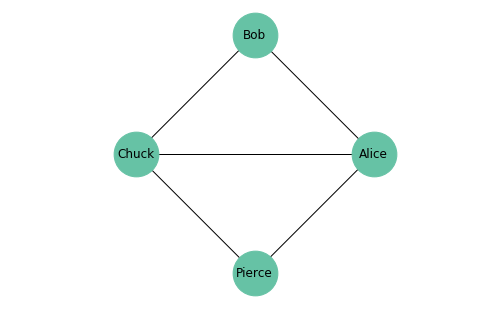

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

G = nx.Graph()

# Add nodes
G.add_node('Alice')
G.add_node('Bob')
G.add_node('Chuck')
G.add_node('Pierce')

# Add edges
G.add_edge('Alice', 'Bob')
G.add_edge('Alice', 'Chuck')
G.add_edge('Bob', 'Chuck')
G.add_edge('Chuck', 'Pierce')
G.add_edge('Pierce', 'Alice')

COLORS = ['#66c2a5']  # colorbrewer2.org

nx.draw_circular(G, node_color=COLORS[0], node_size=2000, with_labels=True)
plt.axis('equal')
plt.show()

## Complete graphs
A complete graph is where each node is connected to every other node.

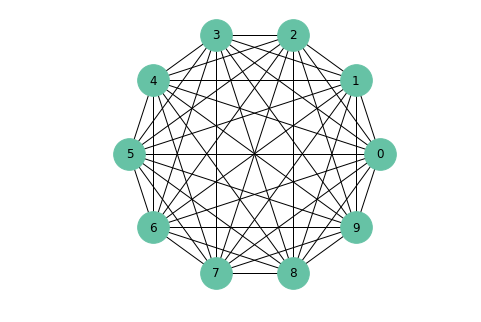

In [4]:
import itertools

def make_complete_graph(n):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(itertools.combinations(nodes, 2))
    return G

complete = make_complete_graph(10)
nx.draw_circular(complete, node_color=COLORS[0], node_size=1000, with_labels=True)
plt.axis('equal')
plt.show()

## Random graph
A random graph is where nodes are connected at random.

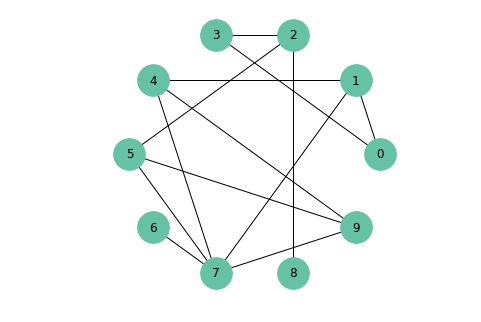

In [5]:
from numpy import random

def random_pairs(nodes, p):
    for x, y in itertools.combinations(nodes, 2):
        if flip(p):
            yield x, y

def make_random_graph(n, p):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_pairs(nodes, p))
    return G

def flip(p):
    return random.random() < p

random.seed(342)
random_graph = make_random_graph(10, 0.3)
nx.draw_circular(random_graph, node_color=COLORS[0], node_size=1000, with_labels=True)
plt.axis('equal')
plt.show()

## Regular graph

In [6]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v
            
list(adjacent_edges('abcde', 1))

[('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'e'), ('e', 'a')]

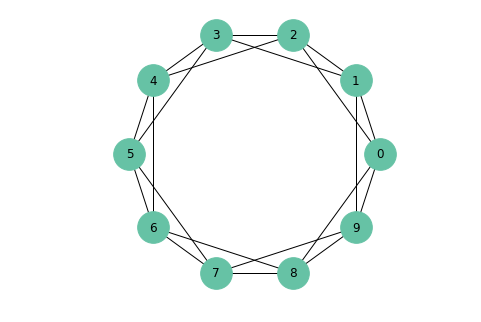

In [7]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

lattice = make_ring_lattice(10, 4)
nx.draw_circular(lattice, node_color=COLORS[0], node_size=1000, with_labels=True)
plt.axis('equal')
plt.show()

## Watts-Strogatz graph
Start with a regular lattice and then rewire

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = random.choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)

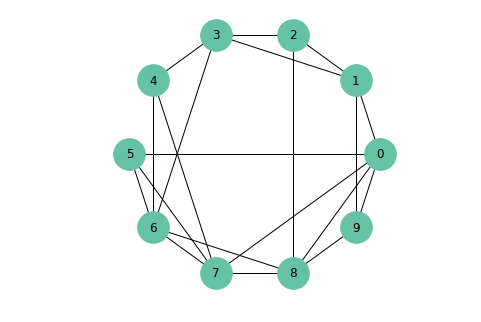

In [9]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, node_color=COLORS[0], node_size=1000, with_labels=True)
plt.axis('equal')
plt.show()

In [10]:
len(lattice.edges()), len(ws.edges())

(20, 20)

## Watts-Strogatz graphs with varying levels of `p`

/usr/local/anaconda3/envs/complexity/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/anaconda3/envs/complexity/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/anaconda3/envs/complexity/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/anaconda3/envs/complexity/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is depreca

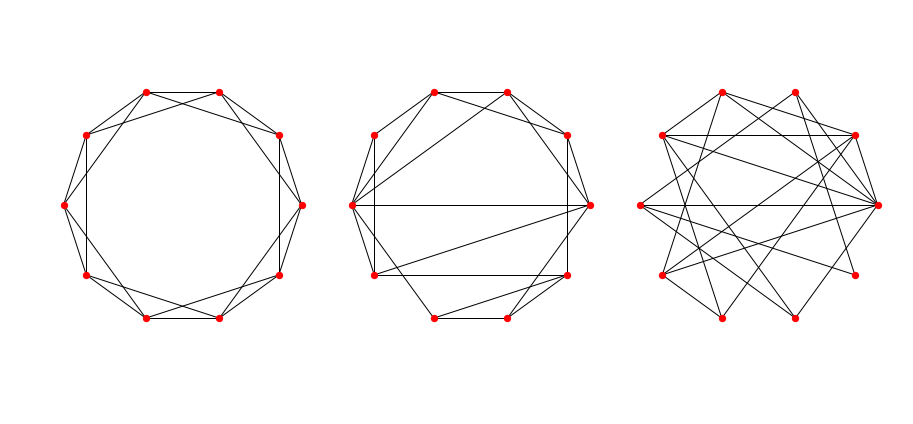

In [19]:
import thinkplot

n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)

# Characterizing "small world" graphs
Watts and Strogatz define small world graphs in terms of their ratio of **clustering** to **path length**.

### Clustering

In [22]:
import numpy

def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in itertools.combinations(neighbors, 2):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = numpy.mean([node_clustering(G, node) for node in G])
    return cc

clustering_coefficient(lattice), clustering_coefficient(random_graph)

(0.5, 0.22999999999999998)

### Path length

In [25]:
import numpy as np

def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in itertools.combinations(G, 2)]
    return lengths

def characteristic_path_length(G):
    return numpy.mean(path_lengths(G))

characteristic_path_length(lattice), characteristic_path_length(random_graph)

(1.6666666666666667, 2.1555555555555554)

## Generating graphs 

In [27]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    return mpl, cc

def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

## Analyzing results

In [16]:
ps = numpy.logspace(-4, 0, 9)
res = run_experiment(ps)

L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = numpy.mean(mpls)
    cc = numpy.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
L = numpy.array(L) / L[0]
C = numpy.array(C) / C[0]

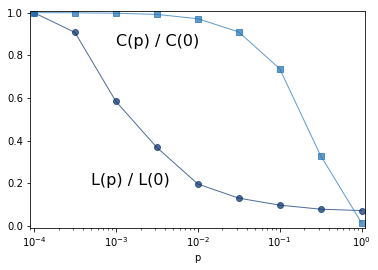

In [17]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])